In [1]:
import numpy as np
import utils
import planners
from models import CostFunction
import constants as c
import matplotlib.pyplot as plt
from planners import feature_height, feature_orientation
import random
import pickle
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


In [2]:
env, robot = utils.setup()

In [3]:
cf = CostFunction(robot, num_dofs=7, normalize=True)
#cf.load_model('./saves/pretrained_ee_random/')
cf.load_model('./saves/learned_ee_cost/')
custom_cost = {'NN': planners.get_trajopt_error_cost(cf)}

INFO:tensorflow:Restoring parameters from ./saves/learned_ee_cost/


In [4]:
def ee_traj_cost(x):
    x = x.reshape((10,7))
    ee_positions = np.stack([utils.get_ee_coords(robot, wp)
                             for wp in x])
    ee_cost = np.sum(np.square(np.diff(ee_positions, axis=0)))
    return ee_cost

ee_cost = {
    'ee_cost': ee_traj_cost
}

## Random pretraining

In [5]:
loss = []
for i in range(10000):
    x = np.random.uniform(0, 2*np.pi, size=(2, 10, 7))
    with env:
        loss.append(cf.train_pref(x[0:1], x[1:], [
            ee_traj_cost(x[1]) > ee_traj_cost(x[0])]))

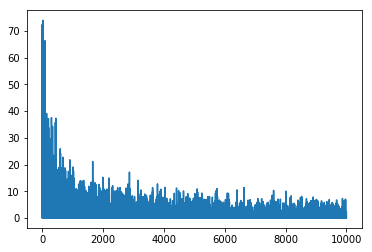

In [6]:
plt.plot(loss)

In [7]:
cf.save_model('./saves/pretrained_ee_random/')

## Generate Demos

In [5]:
'''
demos = {}
for start_idx, goal_idx in c.sg_test_idcs:
    with env:
        robot.SetActiveDOFValues(c.configs[start_idx])
        wps = planners.trajopt_simple_plan(
            env, robot, c.configs[goal_idx],
            custom_traj_costs=ee_cost, joint_vel_coeff=0).GetTraj()
        demos[(start_idx,goal_idx)] = wps
        print('Finished generating for start {:d} and end {:d}'.format(start_idx, goal_idx))
with open('./data/min_ee_disp_demos.pkl', 'wb') as f:
    pickle.dump(demos2, f)
'''
with open('./data/min_ee_disp_demos.pkl', 'rb') as f:
    demos = pickle.load(f)

## Adaptive training

In [6]:
np.mean([ee_traj_cost(demos[key]) for key in demos])

0.11890144382466548

In [7]:
loss_history = []
tq = utils.TrainingQueue(maxsize=100)
#prev_results = {}
for i in range(10):
    results = []
    with env:
        losses = []
        for idcs in c.sg_test_idcs:
            start_idx, goal_idx = idcs
            robot.SetActiveDOFValues(c.configs[start_idx])
            #init = prev_results[idcs] if idcs in prev_results else None
            wps = planners.trajopt_simple_plan(
                env, robot, c.configs[goal_idx],
                custom_traj_costs=custom_cost,
                joint_vel_coeff=0).GetTraj()
            #prev_results[idcs] = wps
            losses.append(ee_traj_cost(wps))
            cf.train_pref(demos[idcs][None], wps[None], [0])
            tq.add((idcs, wps))
        loss_history.append(np.mean(losses))
    for j in range(10 * len(tq)):
        offset = np.zeros((10, 7))
        offset[:,0] += np.random.uniform(0, 2*np.pi)
        idcs, wps = tq.sample()
        A = np.mod(demos[idcs] + offset, 2*np.pi)
        B = np.mod(wps + offset, 2*np.pi)
        cf.train_pref(A[None], B[None], [0])
    print('{:d}: {:.4f}'.format(i, loss_history[-1]))

0: 19.5006
1: 0.4199
2: 0.7607
3: 0.6522
4: 0.2505
5: 0.2339
6: 0.1831
7: 0.1888
8: 0.1378
9: 0.1167


In [8]:
cf.save_model('./saves/learned_ee_cost/')

In [19]:
robot.SetActiveDOFValues(c.configs[0])

In [5]:
with env:
    wps = planners.trajopt_simple_plan(
        env, robot, c.configs[1],
        custom_traj_costs=custom_cost,
        joint_vel_coeff=0).GetTraj()

In [10]:
traj = utils.waypoints_to_traj(env, robot, wps, 1, None)

In [13]:
robot.ExecuteTrajectory(traj)

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

In [7]:
with env:
    wps_default = planners.trajopt_simple_plan(
        env, robot, c.configs[1],
        custom_traj_costs=ee_cost,
        joint_vel_coeff=0).GetTraj()

In [10]:
cf.get_traj_cost(wps[None])

array(29.701122283935547, dtype=float32)

In [9]:
cf.get_traj_cost(wps_default[None])

array(44.3814811706543, dtype=float32)

In [6]:
ee_traj_cost(wps)

0.37003717076832193

In [11]:
ee_traj_cost(wps_default)

0.20585611278831784